In [241]:
#Loading Important libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re #Using regex to extract date and time
import sklearn
from fancyimpute import KNN
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [242]:
#Loading Data set
os.chdir("C:/Users/Deepanshu/Desktop/Data science/bike rental")
day = pd.read_csv("day.csv", parse_dates= True, engine = 'python') 

In [243]:
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [244]:
day = day.drop("instant", axis = 1)
#dropping instant variable as there is no need of this

In [245]:
day.shape

(731, 15)

In [246]:
#We have 731 observations and 15 variables after dropping instant variable.
#Also here dteday variable is not needed as predictor because we already have the seperate mnth and weekday predictors
#so here we can use dteday as a index


In [247]:
for i in range(len(day)):
    day["dteday"].iloc[i] = pd.to_datetime(day["dteday"].iloc[i], errors = 'coerce', dayfirst = True)
day["dteday"] = day["dteday"].dt.strftime("%d-%m-%Y")
day = day.set_index("dteday")

In [248]:
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,
01-01-2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
02-01-2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
03-01-2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
04-01-2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
05-01-2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [249]:
day.dtypes

season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

Missing value analysis

In [250]:
day.isnull().sum()
#there are no missing values in the data

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Outlier Analysis

In [251]:
num_pred = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

(-1, 1)

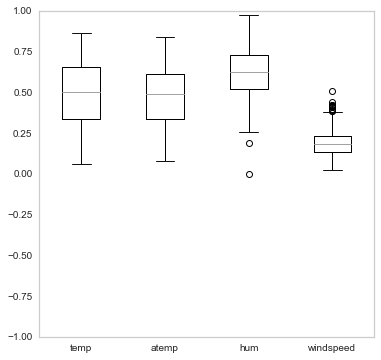

In [252]:
bp1 = day.boxplot(column = ['temp', 'atemp', 'hum', 'windspeed'] , figsize = (6,6), grid = False)
bp1.set_ylim(-1,1)

- As we can see that there are only two outliers in 'hum' variable and very less outliers in "windispeed" vraiable, so there is possibility that these outliers are indicating the exception values

(1500, 5000)

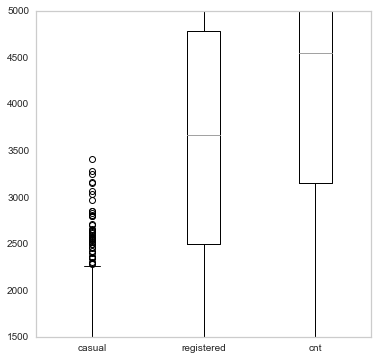

In [253]:
bp2 = day.boxplot(column = ['casual', 'registered','cnt'] , figsize = (6,6), grid = False)
bp2.set_ylim(1500,5000)

In [254]:
#function for finding outliers and converting them into nan
def outlier_treat(x):
    q75,q25 = np.percentile(day[x], [75,25])
    iqr = q75 - q25
    min1 = q25 - (iqr*1.5)
    max1 = q75 + (iqr*1.5)
    day.loc[day[x] < min1, x] = np.nan
    day.loc[day[x] > max1, x] = np.nan

In [255]:
outlier = ['casual', 'registered','cnt']

In [256]:
for i in outlier:
    outlier_treat(i)

In [257]:
day.isnull().sum() #so calculating mathematically we got total 59 outliers 
#we can impute these by KNN Imputation

season         0
yr             0
mnth           0
holiday        0
weekday        0
workingday     0
weathersit     0
temp           0
atemp          0
hum            0
windspeed      0
casual        44
registered     0
cnt            0
dtype: int64

In [258]:
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,
01-01-2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331.0,654.0,985.0
02-01-2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131.0,670.0,801.0
03-01-2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120.0,1229.0,1349.0
04-01-2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108.0,1454.0,1562.0
05-01-2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82.0,1518.0,1600.0


Feature Binning

 After visualizing the data on tableau, we can conclude the following statements:
 - The yr variable contains equally distributed sum of count so there is no need of any change reguired in that.
 - The mnth variable shows different trends but comparing with season variable, it doesn't match much. SO here according to our data we can impute the new_month variable based on the sum of bike renting in different months by binning.
 - After comparing the weekday variable w.r.t sum of cnt and plotting the holiday and working day as filters, the trend show that we holiday and working day are showing exactly same result and are reverse of each other, so we can drop holiday variable from data as the working day variable also gives the information of holiday variable  and binning on weekday can be performed as 1-5 as weekday and 0,6 as weekend.

Function for treating categorical variables

In [259]:
def h(x):
    if (x >=1) and (x <= 5):
        return "weekday"
    elif (x == 0)|(x == 6):
        return "weekend"
def g(x):
    if (x >=1) and (x <= 2):
        return 'year_begin'
    elif (x >=3) and (x <= 4):
        return 'year_mid1'
    elif (x >= 5) and (x <= 10):
        return'year_mid'
    elif (x >=11) and (x <= 12) :
        return 'year_end'
        

In [260]:
day['New_month'] = day['mnth'].apply(g)
day = day.drop(['mnth'], axis =1)
day['Day'] = day['weekday'].apply(h)
day = day.drop(['weekday'], axis =1)

creating dummies and dropping unwanted categorical variables

In [261]:
daydu = day.copy()

In [262]:
temp = pd.get_dummies(daydu['New_month'], prefix = 'New_month')
daydu = daydu.join(temp)
temp = pd.get_dummies(daydu['Day'], prefix = 'Day')
daydu = daydu.join(temp)
temp = pd.get_dummies(daydu['season'], prefix = 'season')
daydu = daydu.join(temp)
temp = pd.get_dummies(daydu['weathersit'], prefix = 'weathersit')
daydu = daydu.join(temp)

we will drop one column from each one-hot-encoded variables

In [263]:
daydu = daydu.drop(['New_month','Day', 'season', 'weathersit', 'season_4', 'weathersit_2', 'Day_weekend', 'New_month_year_mid1', 'holiday' ], axis =1)

In [264]:
daydu.columns

Index(['yr', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'New_month_year_begin', 'New_month_year_end',
       'New_month_year_mid', 'Day_weekday', 'season_1', 'season_2', 'season_3',
       'weathersit_1', 'weathersit_3'],
      dtype='object')

Feature Selection

Correlation analysis

In [265]:
num_pred = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

In [266]:
df_corr = daydu.loc[:, num_pred]

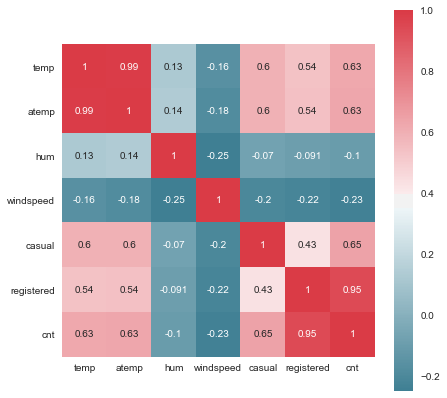

In [267]:
f, ax = plt.subplots(figsize = (7 , 7))
corr1 = df_corr.corr()
sns.heatmap(corr1, cmap = sns.diverging_palette(220,10,as_cmap = True), square = True,annot=True)

- temp and atemp are highly correlated and they both are predictors. so we can drop one of them based on variance 
- also cnt variable that is target variable is sum of casual and registered. That is why they are highly correlated. so we can drop both casual and registered as they will be of no use in prediction.

In [268]:
daydu = daydu.drop(['casual', 'registered'], axis =1)

In [269]:
daydu.columns

Index(['yr', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt',
       'New_month_year_begin', 'New_month_year_end', 'New_month_year_mid',
       'Day_weekday', 'season_1', 'season_2', 'season_3', 'weathersit_1',
       'weathersit_3'],
      dtype='object')

Feature importance test

In [270]:
from sklearn.ensemble import ExtraTreesRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor as vf
from statsmodels.tools.tools import add_constant

In [271]:
drop_col = ['cnt']
reg = ExtraTreesRegressor(n_estimators=200)
X = daydu.drop(columns= drop_col)
y = daydu['cnt']
reg.fit(X, y)

imp_feat = pd.DataFrame({'Feature': daydu.drop(columns=drop_col).columns,'importance':reg.feature_importances_})
imp_feat.sort_values(by = 'importance', ascending=False).reset_index(drop = True)

,Feature,importance
0,yr,0.314423
1,temp,0.159696
2,atemp,0.142738
3,season_1,0.127164
4,New_month_year_mid,0.091786
5,weathersit_3,0.032847
6,hum,0.032838
7,weathersit_1,0.028485
8,windspeed,0.024155
9,season_2,0.010954


In [272]:
# checking vif of numerical column withhout dropping multicollinear column -> see output
numeric_df = add_constant(daydu[['temp', 'atemp', 'hum', 'windspeed']])
vif = pd.Series([vf(numeric_df.values, i) for i in range(numeric_df.shape[1])],
index = numeric_df.columns)
vif.round(1)


const        45.6
temp         63.0
atemp        63.6
hum           1.1
windspeed     1.1
dtype: float64

In [273]:
# Checking VIF values of numeric columns after dropping column atemp -> see output
numeric_df = add_constant(daydu[['temp', 'hum', 'windspeed']])
vif = pd.Series([vf(numeric_df.values, i) for i in range(numeric_df.shape[1])],
index = numeric_df.columns)
vif.round(1)

const        41.1
temp          1.0
hum           1.1
windspeed     1.1
dtype: float64

Hence from variable importance and VIF values, we can conclude that we can drop atemp variable

In [274]:
daydu = daydu.drop(['atemp'], axis =1)

Anova test

In [275]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [276]:
model = ols('cnt ~ C(yr)+ C(workingday) + C(New_month_year_begin) +C(New_month_year_end) + C(New_month_year_mid) +C(Day_weekday) + C(season_1) + C(season_2) + C(season_3)+ C(weathersit_1) + C(weathersit_3)', data=daydu).fit()
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(yr),1.0,8.798289e+08,8.798289e+08,1141.869113,1.289116e-150
C(workingday),1.0,1.063183e+07,1.063183e+07,13.798312,2.192940e-04
C(New_month_year_begin),1.0,6.277188e+08,6.277188e+08,814.672808,2.154733e-120
C(New_month_year_end),1.0,1.806462e+08,1.806462e+08,234.448156,5.163645e-46
C(New_month_year_mid),1.0,1.977151e+08,1.977151e+08,256.600729,1.295598e-49
C(Day_weekday),1.0,2.794016e+06,2.794016e+06,3.626161,5.727677e-02
C(season_1),1.0,8.528975e+07,8.528975e+07,110.691676,3.551957e-24
C(season_2),1.0,4.358320e+06,4.358320e+06,5.656363,1.765245e-02
C(season_3),1.0,5.420027e+05,5.420027e+05,0.703428,4.019130e-01
C(weathersit_1),1.0,1.258817e+08,1.258817e+08,163.373131,7.397619e-34


Hypothesis testing :

- Null Hypothesis: mean of all categories in a variable are same.
- Alternate Hypothesis: mean of at least one category in a variable is different.
- If p-value is less than 0.05 then we reject the null hypothesis.
- And if p-value is greater than 0.05 then we accept the null hypothesis.

Here all p values are less than 0.05 , so we reject null hypothesis

Feature scaling

3752788.2082828935


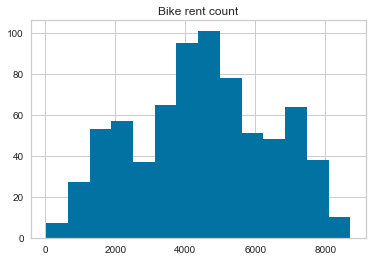

In [277]:
hist1 = plt.hist(daydu["cnt"], bins = 'auto') #normally distrubted, so no need of any feature scaling technique.
plt.title("Bike rent count")
print(daydu["cnt"].var())

After applying normalization the target variable , it shows very less variation but also gives less accuracy, so we will drop the idea of normalizing and the other continuous variables are already normalized.

In [278]:
cols = list(daydu.columns.values)
print(cols)

['yr', 'workingday', 'temp', 'hum', 'windspeed', 'cnt', 'New_month_year_begin', 'New_month_year_end', 'New_month_year_mid', 'Day_weekday', 'season_1', 'season_2', 'season_3', 'weathersit_1', 'weathersit_3']


In [279]:
daydu = daydu[['cnt', 'yr', 'workingday', 'temp', 'hum', 'windspeed', 'New_month_year_begin', 'New_month_year_end', 'New_month_year_mid', 'Day_weekday', 'season_1', 'season_2', 'season_3', 'weathersit_1', 'weathersit_3']]

In [280]:
daydu

,cnt,yr,workingday,temp,hum,windspeed,New_month_year_begin,New_month_year_end,New_month_year_mid,Day_weekday,season_1,season_2,season_3,weathersit_1,weathersit_3
dteday,,,,,,,,,,,,,,,
01-01-2011,985.0,0,0,0.344167,0.805833,0.160446,1,0,0,0,1,0,0,0,0
02-01-2011,801.0,0,0,0.363478,0.696087,0.248539,1,0,0,0,1,0,0,0,0
03-01-2011,1349.0,0,1,0.196364,0.437273,0.248309,1,0,0,1,1,0,0,1,0
04-01-2011,1562.0,0,1,0.200000,0.590435,0.160296,1,0,0,1,1,0,0,1,0
05-01-2011,1600.0,0,1,0.226957,0.436957,0.186900,1,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27-12-2012,2114.0,1,1,0.254167,0.652917,0.350133,0,1,0,1,1,0,0,0,0
28-12-2012,3095.0,1,1,0.253333,0.590000,0.155471,0,1,0,1,1,0,0,0,0
29-12-2012,1341.0,1,0,0.253333,0.752917,0.124383,0,1,0,0,1,0,0,0,0


# Modeling

- Now we have our processed data and we can perform modelling on this data.
- so now we will split this data into two parts in Train and test with 80% and 20% weightage respectively.

In [281]:
from sklearn.model_selection import train_test_split

In [282]:
X = daydu.values[:,1:16]
Y = daydu.values[:, 0 ]
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size = 0.25)

# -----------------Error Metrics--------------------- 

In [283]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import linear_model
from yellowbrick.regressor import PredictionError
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn import neighbors
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from scipy.stats import randint as sp_randint
import xgboost as xgb
import joblib

In [284]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

In [285]:
#10 K-Fold cross validation
from sklearn.model_selection import cross_val_score
def cross(regressor):
    regressor.fit(xtrain, ytrain)
    ypred = regressor.predict(xtest)
    cross_score = cross_val_score(estimator= regressor, X=xtrain, y=ytrain, cv = 10,scoring='r2')
    k_fold_performance = cross_score.mean()
    print(k_fold_performance)

In [286]:
#Defining functions to calculate error metrics of training and on test data
def scores(y, y_):
    print('Accuracy: {}'.format(metrics.r2_score(y, y_)*100))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-xtrain.shape[1]-1)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_)))
def test_scores(model):
    print("The scores of the model are:")
    print("................................")
    print('10 K-Fold crossval score')
    print()
    cross(model)
    print('................................')
    print('On training data ERROR METRICS')
    print()
    #Predicting result on Training data
    ypred = model.predict(xtrain)
    scores(ytrain,ypred)
    print('...............................')
    print('On testing data  ERROR METRICS')
    print()
    # Evaluating on Test Set
    ypred = model.predict(xtest)
    scores(ytest,ypred)

# -------------------Model Selection---------------

In [287]:
def modeleval(model):
    # Fit the regressor to the training data
    model.fit(xtrain,ytrain)
    # Predict on the test data: y_pred
    ypred = model.predict(xtest)
    test_scores(model)

In [288]:
#function for plotting prediction error plot
def prederror(model):
    visualizer = PredictionError(model)
    visualizer.fit(xtrain, ytrain)  # Fit the training data to the visualizer
    visualizer.score(xtest, ytest)  # Evaluate the model on the test data
    visualizer.show()

In [289]:
#function for plotting feature importances in model
def importance(model):
    plt.title("Test Importance")
    sns.barplot(y=cols, x=list(model.feature_importances_))

In [290]:
def tune(model, param):
    regcv = RandomizedSearchCV(model, param, cv=5)
    regcv.fit(X, Y)
    print("Tuned Decision reg Parameters: {}".format(regcv.best_params_))
    print("Best score is {}".format(regcv.best_score_))

----Multiple Linear Regression----

The scores of the model are:
................................
10 K-Fold crossval score

0.803550554972573
................................
On training data ERROR METRICS

Accuracy: 82.3236630116129
Adjusted r square:0.8185936898189916
RMSE: 799.8000599563259
...............................
On testing data  ERROR METRICS

Accuracy: 85.6040213160993
Adjusted r square:0.8440435642577424
RMSE: 770.9632626285403


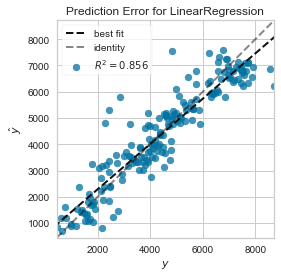

In [291]:
MLRmodel = linear_model.LinearRegression()
modeleval(MLRmodel)
prederror(MLRmodel)
ypred_mlr = MLRmodel.predict(xtrain)
ypred_mlr_test = MLRmodel.predict(xtest)

The scores of the model are:
................................
10 K-Fold crossval score

0.737238227363908
................................
On training data ERROR METRICS

Accuracy: 100.0
Adjusted r square:1.0
RMSE: 0.0
...............................
On testing data  ERROR METRICS

Accuracy: 78.78418950980725
Adjusted r square:0.7701620530229119
RMSE: 935.928991164785


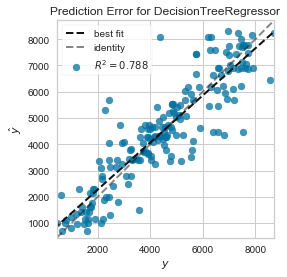

In [292]:
DTmodel = DecisionTreeRegressor()
modeleval(DTmodel)
prederror(DTmodel)
ypred_dT = DTmodel.predict(xtrain)

# Ensemble

The scores of the model are:
................................
10 K-Fold crossval score

0.8560237183797904
................................
On training data ERROR METRICS

Accuracy: 97.87010509092768
Adjusted r square:0.9781416038412278
RMSE: 277.62871555461476
...............................
On testing data  ERROR METRICS

Accuracy: 90.64147682378517
Adjusted r square:0.8986159989243394
RMSE: 621.6082166649185


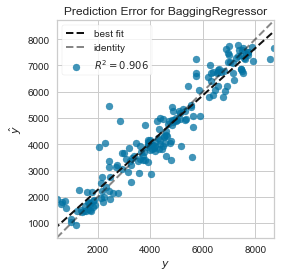

In [296]:
bc = BaggingRegressor( n_estimators= 162)
modeleval(bc)
prederror(bc)
ypred_br = bc.predict(xtrain)
ypred_br_test = bc.predict(xtest)

------XGBoost-------

In [297]:
xgboost = xgb.XGBRegressor()
xg_param = [{'n_estimators' : [250, 300,350, 400,450], 'max_depth':[2, 3, 5],'learning_rate':[0.01, 0.07, 0.045, 0.05, 0.055, 0.1, 0.3],'gamma':[0, 0.001, 0.01, 0.03],'subsample':[1, 0.7, 0.8, 0.9],'random_state' :[1]}]

Tuned Decision reg Parameters: {'subsample': 0.9, 'random_state': 1, 'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0}

In [298]:
xgboost = xgb.XGBRegressor(subsample= 0.9, random_state= 1, n_estimators= 400, max_depth = 2, learning_rate = 0.05, gamma = 0)
# Fit the regressor to the training data
xgboost.fit(xtrain,ytrain)
# Predict on the test data: y_pred
ypred_xgb = xgboost.predict(xtrain)
ypred_xgb_test = xgboost.predict(xtest)
test_scores(xgboost)

The scores of the model are:
................................
10 K-Fold crossval score

0.8747140010538731
................................
On training data ERROR METRICS

Accuracy: 93.62880256503387
Adjusted r square:0.9346145403953756
RMSE: 480.1708901114432
...............................
On testing data  ERROR METRICS

Accuracy: 89.6399493671011
Adjusted r square:0.8877661181435953
RMSE: 654.0245119236546


# Final result with partial Stacking with Neural networks

Neural networks

In [300]:
stack_data_train = pd.DataFrame({ 'BR': ypred_br, 'XGB': ypred_xgb})

In [301]:
stack_data_test = pd.DataFrame({'BR': ypred_br_test, 'XGB': ypred_xgb_test})

In [303]:
Xntrain = stack_data_train.values
Yntrain = ytrain.copy()
Xntest = stack_data_test.values
Yntest = ytest.copy()

In [304]:
ytrain = np.reshape(Yntrain, (-1,1))
ytest = np.reshape(Yntest, (-1,1))
xtrain= Xntrain
xtest = Xntest

In [311]:
model = Sequential()
#input layer
model.add(Dense(2, input_dim= xtrain.shape[1], kernel_initializer='normal', bias_initializer ='zeros', activation='relu'))
#hidden layers
model.add(Dense(12, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(9, kernel_initializer='he_uniform',  activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(8, kernel_initializer='he_uniform', activation='relu'))
#output layer
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_72 (Dense)             (None, 12)                36        
_________________________________________________________________
dense_73 (Dense)             (None, 9)                 117       
_________________________________________________________________
dense_74 (Dense)             (None, 9)                 90        
_________________________________________________________________
dense_75 (Dense)             (None, 9)                 90        
_________________________________________________________________
dense_76 (Dense)             (None, 8)                 80        
_________________________________________________________________
dense_77 (Dense)             (None, 1)               

In [312]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss='mse', optimizer= opt , metrics=['mse','accuracy'])

In [313]:
model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs= 1000, batch_size= len(xtrain))

Train on 548 samples, validate on 183 samples
Epoch 1/1000
548/548 [==============================] - 0s 627us/step - loss: 23137444.0000 - mse: 23137444.0000 - accuracy: 0.0000e+00 - val_loss: 22854544.0000 - val_mse: 22854544.0000 - val_accuracy: 0.0000e+00
Epoch 2/1000
548/548 [==============================] - 0s 19us/step - loss: 23026682.0000 - mse: 23026682.0000 - accuracy: 0.0000e+00 - val_loss: 22772128.0000 - val_mse: 22772128.0000 - val_accuracy: 0.0000e+00
Epoch 3/1000
548/548 [==============================] - 0s 13us/step - loss: 22943008.0000 - mse: 22943008.0000 - accuracy: 0.0000e+00 - val_loss: 22683234.0000 - val_mse: 22683234.0000 - val_accuracy: 0.0000e+00
Epoch 4/1000
548/548 [==============================] - 0s 11us/step - loss: 22852768.0000 - mse: 22852768.0000 - accuracy: 0.0000e+00 - val_loss: 22585868.0000 - val_mse: 22585868.0000 - val_accuracy: 0.0000e+00
Epoch 5/1000
548/548 [==============================] - 0s 4us/step - loss: 22753926.0000 - mse: 2275

In [314]:
ypredtest = model.predict(xtest)
ypredtest = np.reshape(ypredtest, 183)

In [315]:
ypredtrain = model.predict(xtrain)
ypredtrain = np.reshape(ypredtrain, 548)

In [319]:
print('On training data ERROR METRICS')
print()
#Predicting result on Training data
print('Accuracy: {}'.format(metrics.r2_score(ytrain, ypredtrain)*100))
print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(ytrain, ypredtrain))*(len(y)-1)/(len(y)-xtrain.shape[1]-1)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(ytrain, ypredtrain)))
print('...............................')
print('On testing data  ERROR METRICS')
print()
# Evaluating on Test Set
print('Accuracy: {}'.format(metrics.r2_score(ytest, ypredtest)*100))
print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(ytest, ypredtest))*(len(y)-1)/(len(y)-xtrain.shape[1]-1)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypredtest)))

On training data ERROR METRICS

Accuracy: 96.40241615855278
Adjusted r square:0.963925326864609
RMSE: 360.8201295088381
...............................
On testing data  ERROR METRICS

Accuracy: 91.2743153103051
Adjusted r square:0.9125034364906968
RMSE: 600.223291457978


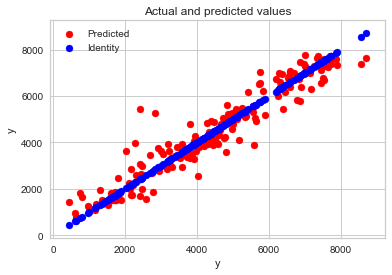

In [320]:
_, ax = plt.subplots()

ax.scatter(x = ytest_p, y=ypred_p, c = 'red', label = 'Predicted', alpha = 1)
ax.scatter(x = ytest_p, y=ytest_p, c = 'blue', label = 'Identity', alpha = 1)

plt.title('Actual and predicted values')
plt.xlabel('y')
plt.ylabel('y')
plt.legend()
plt.show()